In [1]:
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp

In [2]:
import os
# propriatary mnist management
DATASETSLIB_HOME = './datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

/home/hackerman/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pandas as pd
import numpy as np
filename = os.path.join(datasetslib.datasets_root,'international-airline-passengers.csv')
dataframe = pd.read_csv(filename,usecols=[1],header=0)
dataset = dataframe.values
dataset = dataset.astype(np.float32)

In [4]:
scaler = pp.MinMaxScaler(feature_range=(0,1))
normalized_dataset = scaler.fit_transform(dataset)

In [5]:
train,test=dsu.train_test_split(normalized_dataset,train_size=0.67)

In [6]:
n_x=1
n_y=1
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train,test,n_x=n_x,n_y=n_y)

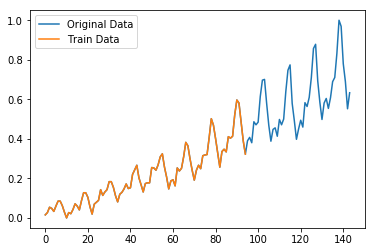

In [7]:
plt.plot(normalized_dataset,label='Original Data')
plt.plot(X_train,label='Train Data')
plt.legend()
plt.show()

In [8]:
state_size = 4
n_epochs = 1000
n_timesteps = n_x
learning_rate = 0.1
n_x_vars = 1
n_y_vars = 1

In [9]:
train,test=dsu.train_test_split(normalized_dataset,train_size=0.67)

In [10]:
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train,
test,n_x=n_x,n_y=n_y)

In [11]:
import tensorflow as tf

In [12]:
tf.reset_default_graph()

In [13]:
X_p = tf.placeholder(tf.float32,[None,n_timesteps,n_x_vars],name='X_p')
Y_p = tf.placeholder(tf.float32,[None,n_timesteps,n_y_vars],name='Y_p')

In [14]:
rnn_inputs = tf.unstack(X_p,axis=1)

In [15]:
# attempt 1
# cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
# attempt 2
# cell = tf.nn.rnn_cell.LSTMCell(state_size)
# attempt 3
cell = tf.nn.rnn_cell.GRUCell(state_size)

In [16]:
rnn_outputs, final_state = tf.nn.static_rnn(cell,rnn_inputs,dtype=tf.float32)

In [17]:
W = tf.get_variable('W',[state_size,n_y_vars])
b = tf.get_variable('b',[n_y_vars], initializer=tf.constant_initializer(0.0))
predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]

In [18]:
y_as_list = tf.unstack(Y_p,num=n_timesteps,axis=1)

In [19]:
mse = tf.losses.mean_squared_error
losses = [mse(labels=label, predictions=prediction) for prediction, label in zip(predictions, y_as_list)]

In [20]:
total_loss = tf.reduce_mean(losses)

In [21]:
n_timesteps

1

In [22]:
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)


In [23]:
n_epochs

1000

In [27]:
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    epoch_loss = 0.0
    for epoch in range(n_epochs):
        feed_dict={X_p: X_train.reshape(-1, n_timesteps, 
                                        n_x_vars), 
                   Y_p: Y_train.reshape(-1, n_timesteps, 
                                        n_x_vars)
                  }
        
        epoch_loss,y_train_pred,_=tfs.run([total_loss,predictions,optimizer], 
                                            feed_dict=feed_dict
                                           )
    print("train mse = {}".format(epoch_loss))
    feed_dict={X_p: X_test.reshape(-1, n_timesteps, 
                                    n_x_vars), 
               Y_p: Y_test.reshape(-1, n_timesteps, 
                                    n_y_vars)
              }
    test_loss, y_test_pred = tfs.run([total_loss,predictions], 
                                     feed_dict=feed_dict
                                    )
    print('test mse = {}'.format(test_loss))
    print('test rmse = {}'.format(np.sqrt(test_loss)))

train mse = 0.0019266330637037754
test mse = 0.010709842666983604
test rmse = 0.10348837077617645


In [30]:
y_test_pred

[array([[0.40089086],
        [0.37677032],
        [0.46902826],
        [0.4560428 ],
        [0.46741363],
        [0.5698816 ],
        [0.6291928 ],
        [0.63182473],
        [0.5435267 ],
        [0.45440865],
        [0.38370332],
        [0.4362767 ],
        [0.4429031 ],
        [0.40600574],
        [0.47866413],
        [0.4560428 ],
        [0.48026136],
        [0.5883595 ],
        [0.6625253 ],
        [0.67968345],
        [0.5435267 ],
        [0.47385737],
        [0.39232337],
        [0.43793678],
        [0.4754621 ],
        [0.44620228],
        [0.5464988 ],
        [0.5315305 ],
        [0.5669973 ],
        [0.638355  ],
        [0.72897124],
        [0.7407681 ],
        [0.62654954],
        [0.54798067],
        [0.47866413],
        [0.545014  ],
        [0.56264997],
        [0.5239458 ],
        [0.5655508 ],
        [0.62389505],
        [0.638355  ],
        [0.71460736],
        [0.80226254],
        [0.7875954 ],
        [0.68328846],
        [0

In [25]:
y_train_pred=y_train_pred[0]
y_test_pred=y_test_pred[0]

In [26]:
#invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

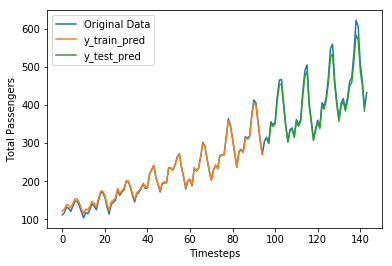

In [73]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :] = y_test_pred
# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()